# Load dataset

In [1]:
# Import modules
import pandas as pd

# Create data frame
df = pd.read_csv("data.csv")

# Check for missing values

In [2]:
# Check for the sum of null values for each feature
print(df.isnull().sum())

basket_icon_click          0
basket_add_list            0
basket_add_detail          0
sort_by                    0
image_picker               0
account_page_click         0
promo_banner_click         0
detail_wishlist_add        0
list_size_dropdown         0
closed_minibasket_click    0
checked_delivery_detail    0
checked_returns_detail     0
sign_in                    0
saw_checkout               0
saw_sizecharts             0
saw_delivery               0
saw_account_upgrade        0
saw_homepage               0
device_mobile              0
device_computer            0
device_tablet              0
returning_user             0
loc_uk                     0
ordered                    0
dtype: int64


# Check for outliers

In [3]:
# Create function to implement IQR method
def remove_outlier_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_final = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))]
    return df_final
 
# Remove outliers
df_outlier_removed = remove_outlier_IQR(df)
df_outlier_removed = pd.DataFrame(df_outlier_removed)
ind_diff = df.index.difference(df_outlier_removed.index)
    
for i in range(0, len(ind_diff),1):
    df_final = df.drop([ind_diff[i]])
    df = df_final
    
# Check number of outliers removed
print('Number of outliers:', len(ind_diff))

Number of outliers: 0


# Feature Selection - Pearson's Correlation Method

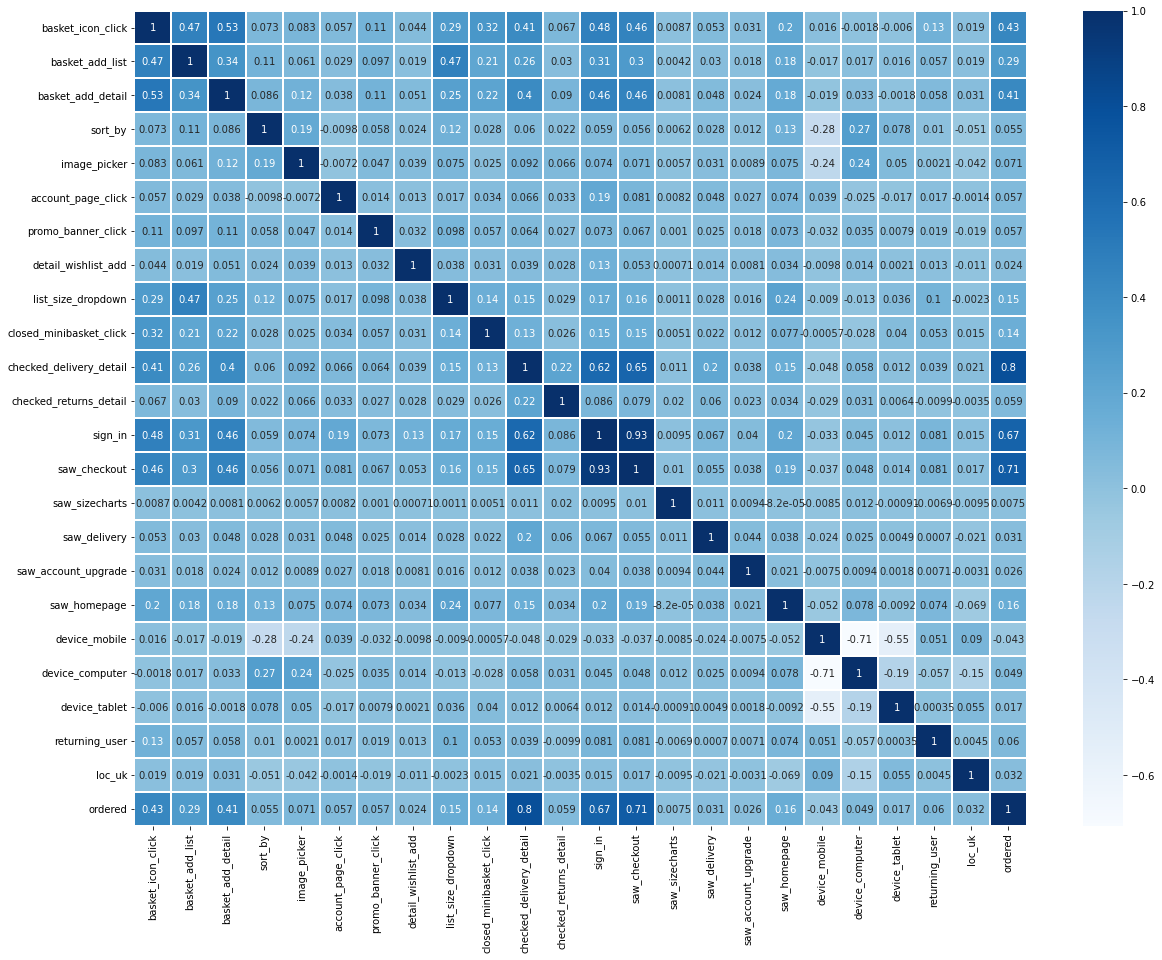

In [4]:
# Import modules
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize = (20,15))
sns.heatmap(df.corr(), linewidth = 2, annot=True, cmap="Blues")
plt.show()

In [5]:
# Correlation with output variable
cor = df.corr()
cor_target = abs(cor["ordered"])

# Selecting features that are highly correlated  with the output
relevant_features = cor_target[cor_target>0.1]
print(relevant_features)

basket_icon_click          0.428334
basket_add_list            0.287666
basket_add_detail          0.414420
list_size_dropdown         0.154867
closed_minibasket_click    0.140011
checked_delivery_detail    0.798720
sign_in                    0.665556
saw_checkout               0.708986
saw_homepage               0.157778
ordered                    1.000000
Name: ordered, dtype: float64


In [6]:
# Keep the higly correleated features and output
df_features = df[['basket_add_detail', 'saw_homepage', 'saw_checkout', 'list_size_dropdown', 'basket_add_list', 'basket_icon_click', 'sign_in', 'closed_minibasket_click', 'checked_delivery_detail', 'ordered']]

In [7]:
# Select features and output
X = df_features.iloc[:, 0:9]
y = df_features.iloc[:, 9]

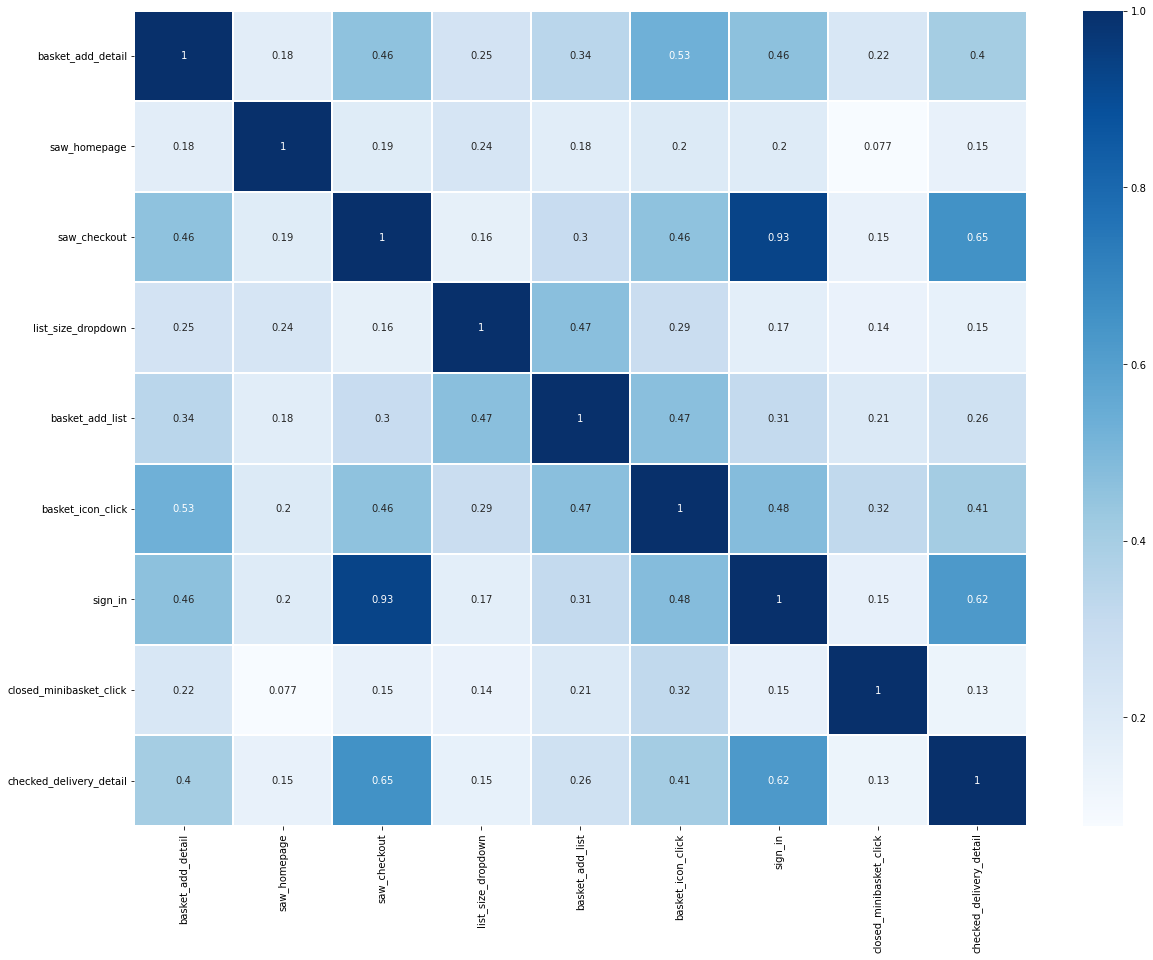

In [8]:
# Plot heatmap
plt.figure(figsize = (20,15))
sns.heatmap(X.corr(), linewidth=2, annot=True, cmap="Blues")
plt.show()

In [9]:
# Select highly correlated features
# Remove the first feature that is correlated above the threshold with any other feature
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # We are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # Getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X, 0.9)

print('Number of correlated features:', len(set(corr_features)))
print('Names of correlated features:', corr_features)

Number of correlated features: 1
Names of correlated features: {'sign_in'}


In [10]:
# Drop correlated features
X = X.drop(corr_features,axis=1)

# Train SVM Classifier

In [11]:
# Import modules
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Instantiate the model (using the default parameters)
svm = svm.SVC()

# Defining parameter range for hyperparameter tuning 
grid_vals = {'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']}

grid = GridSearchCV(estimator = svm, param_grid=grid_vals, scoring='accuracy', 
                    cv=3, return_train_score=True) 

# Fitting the model for grid search 
grid.fit(X_train, y_train) 

# Print best parameters after tuning 
print('Best parameters:', grid.best_params_) 

Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [12]:
# Save the best model
svm_best = grid.best_estimator_

# Predict labels
y_pred = svm_best.predict(X_test)

# Confusion Matrix

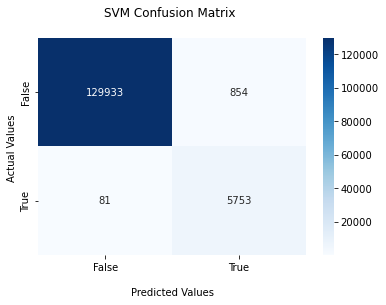

In [13]:
# Imort modules
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt=".0f")

ax.set_title('SVM Confusion Matrix \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Display the visualization of the Confusion Matrix.
plt.show()

# Classification Report

In [14]:
# Import modules
from sklearn.metrics import classification_report

# Create target labels
target_names = ['Did not order', 'Ordered']

# Print classification report
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

Did not order       1.00      0.99      1.00    130787
      Ordered       0.87      0.99      0.92      5834

     accuracy                           0.99    136621
    macro avg       0.94      0.99      0.96    136621
 weighted avg       0.99      0.99      0.99    136621



In [15]:
# Import modules
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate Precision, Recall, Accuracy and F1 Score
print('Precision: %.6f' % precision_score(y_test, y_pred))
print('Recall: %.6f' % recall_score(y_test, y_pred))
print('Accuracy: %.6f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.6f' % f1_score(y_test, y_pred))

Precision: 0.870743
Recall: 0.986116
Accuracy: 0.993156
F1 Score: 0.924845


# ROC - AUC

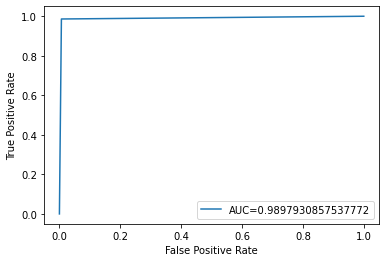

In [16]:
# Import modules
from sklearn import metrics

# Define metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label = "AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 4)
plt.show()